In [1]:
# import the dataset
from google.colab import drive
drive.mount('/content/drive')

import os

small_dataset = ['CNV', 'DME', 'Drusen', 'Normal']
# small_dataset_dir = '/content/drive/MyDrive/APS360 Project - Group 7/Code/small_dataset'
small_dataset_dir = '/content/drive/MyDrive/UofT/Third Year/Summer/APS360/APS360 Project - Group 7/Code/small_dataset' ## change this based on your own google drive directory

def num_images(dir, folders):
    print(f"Number of images in each folder:")
    for folder in folders:
        path = os.path.join(dir, folder)
        if os.path.isdir(path):
            num_files = len(os.listdir(path))
            print(f"{folder}: {num_files}")
        else:
            print(f"Folder '{folder}' does not exist in the dataset directory.")

num_images(small_dataset_dir, small_dataset)

Mounted at /content/drive
Number of images in each folder:
CNV: 50
DME: 50
Drusen: 50
Normal: 50


In [38]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models
from torchvision.models import alexnet

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
dataset = ImageFolder(root=small_dataset_dir, transform=transform)

# split the data: 70% training, 15% validation, 15% testing
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len
train_data, val_data, test_data = random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# define dataloader parameters
batch_size = 32

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# check the number of training, validation, and test images alongside the percentage of training, validation, and testing (check)
print(f"Number of training images: {len(train_data)}  Percent: {100 * len(train_data)/total_len:.2f}")
print(f"Number of validation images: {len(val_data)}  Percent: {100 * len(val_data)/total_len:.2f}")
print(f"Number of test images: {len(test_data)}  Percent: {100 * len(test_data)/total_len:.2f}")

Number of training images: 140  Percent: 70.00
Number of validation images: 30  Percent: 15.00
Number of test images: 30  Percent: 15.00


In [39]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        # select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [40]:
from torchvision.models import alexnet

alexnet_base = alexnet(pretrained=True)

for param in alexnet_base.features.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
class AlexNet_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [42]:
class CombinedAlexNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.features = base_model.features
        self.classifier = AlexNet_Classifier()

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [43]:
model = CombinedAlexNet(alexnet_base)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

In [44]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, train_data, val_data, batch_size=64, learning_rate = 0.001, num_epochs=20):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1

        print(f"Epoch {epoch+1}: Train acc: {train_acc[-1]:.4f} | Validation acc: {val_acc[-1]:.4f}")
        #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        #torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 1: Train acc: 0.4643 | Validation acc: 0.2667
Epoch 2: Train acc: 0.7643 | Validation acc: 0.4667
Epoch 3: Train acc: 0.8643 | Validation acc: 0.4333
Epoch 4: Train acc: 0.9143 | Validation acc: 0.6333
Epoch 5: Train acc: 0.9000 | Validation acc: 0.6000
Epoch 6: Train acc: 0.9786 | Validation acc: 0.5667
Epoch 7: Train acc: 0.9714 | Validation acc: 0.6667
Epoch 8: Train acc: 1.0000 | Validation acc: 0.7000
Epoch 9: Train acc: 1.0000 | Validation acc: 0.6667
Epoch 10: Train acc: 0.9929 | Validation acc: 0.7000
Epoch 11: Train acc: 1.0000 | Validation acc: 0.7667
Epoch 12: Train acc: 1.0000 | Validation acc: 0.7000
Epoch 13: Train acc: 0.9929 | Validation acc: 0.6667
Epoch 14: Train acc: 0.9929 | Validation acc: 0.7000
Epoch 15: Train acc: 0.9929 | Validation acc: 0.7667


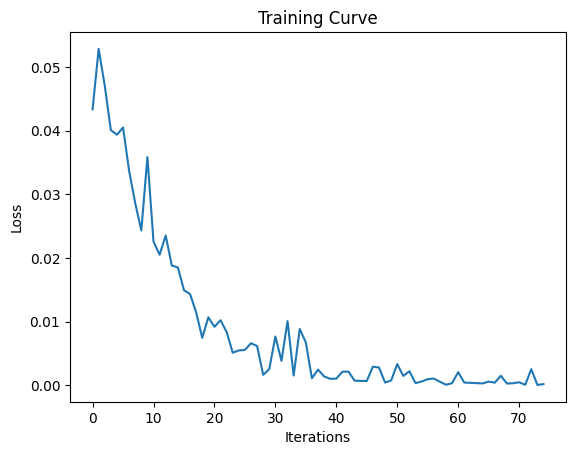

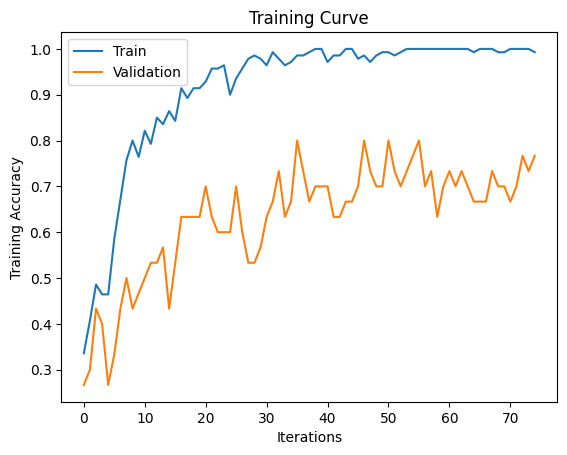

Final Training Accuracy: 0.9928571428571429
Final Validation Accuracy: 0.7666666666666667


In [45]:
train(model, train_data, val_data, batch_size=batch_size, learning_rate=0.001, num_epochs=15)

In [46]:
test_acc = get_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9000


In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix
def plot_confusion_matrix(model, data_loader, class_names):
    # set model into evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = model(imgs)
            preds = output.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

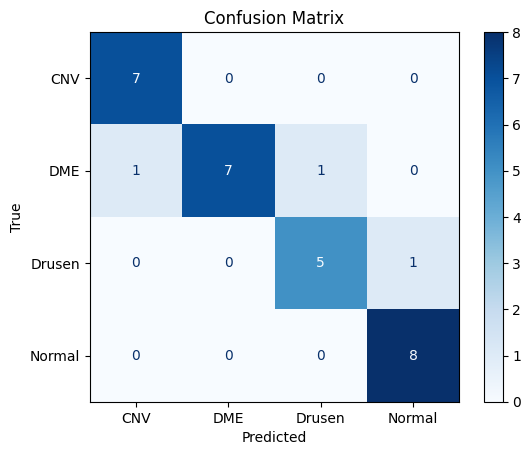

array([[7, 0, 0, 0],
       [1, 7, 1, 0],
       [0, 0, 5, 1],
       [0, 0, 0, 8]])

In [48]:
class_names = ['CNV', 'DME', 'Drusen', 'Normal']
plot_confusion_matrix(model, test_loader, class_names)

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# plot roc curve
def plot_roc_curve(model, data_loader, class_names):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            output = model(imgs)
            probs = torch.softmax(output, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # binarize the labels for multi-class ROC
    y_true = label_binarize(all_labels, classes=np.arange(len(class_names)))
    n_classes = y_true.shape[1]

    # compute ROC and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plot the ROC curve
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # random classfier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc

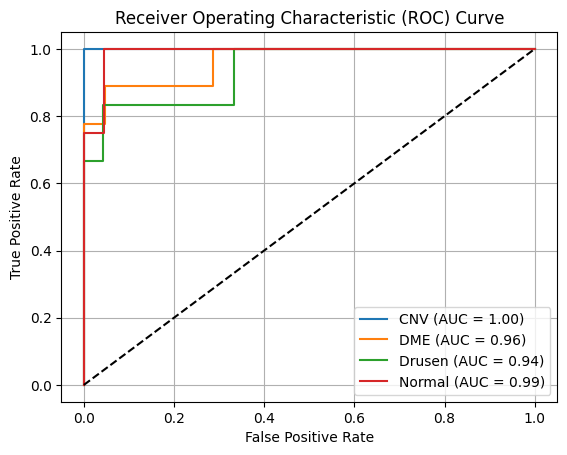

In [51]:
roc_auc = plot_roc_curve(model, test_loader, class_names)